In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from prepare import remove_outliers, train_val_test, x_y_split, mm_scaler, ss_scaler, rs_scaler

from scipy import stats

In [2]:
df = pd.read_csv('used_cars_data.csv', nrows=100000)

In [3]:
df.head()

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,A,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,M,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020


In [4]:
def missing_values(df):
    
    '''
    This function determins how many missing rows are in each column and what percentage it is.
    '''
    
    # determing how many missing rows there are
    missing_df = pd.DataFrame(df.isna().sum(), columns=['num_rows_missing'])
    
    # determining what percentage of the column is missing
    missing_df['pct_rows_missing'] = missing_df['num_rows_missing'] / len(df)
    
    return missing_df

In [5]:
missing_values(df)

,num_rows_missing,pct_rows_missing
vin,0,0.00000
back_legroom,4954,0.04954
bed,99393,0.99393
bed_height,91877,0.91877
bed_length,91877,0.91877
...,...,...
wheel_system,4624,0.04624
wheel_system_display,4624,0.04624
wheelbase,4954,0.04954
width,4954,0.04954


In [6]:
def handle_missing_values(df, prop_required_col, prop_required_row):
    
    '''
    This function drops columns and rows if it is contains a certain percentage of nulls determined by the user.
    '''
    
    # determine how many nulls are needed to meet the threshold and then dropping the column if it meets it
    drop_cols = round(prop_required_col * len(df))
    df.dropna(thresh=drop_cols, axis=1, inplace=True)

    # determine how many nulls are needed to meet the threshold and then dropping the row if it meets it    
    drop_rows = round(prop_required_row * len(df.columns))
    df.dropna(thresh=drop_rows, axis=0, inplace=True)
    
    return df

In [7]:
df = handle_missing_values(df, .5, .5)

In [8]:
def drop_rename_cols(df):
    
    '''
    This function drops columns that do not have useful data and renames other columns to for easier readability.
    '''
    
    # list of columns to be dropped
    drop_cols = ['vin', 'dealer_zip','description',
                 'torque','transmission_display','trimId',
                 'trim_name','wheel_system_display', 'fleet',
                 'height','isCab','latitude','longitude','listing_id',
                 'main_picture_url','major_options','franchise_make',
                 'model_name','power','salvage','listing_color', 
                 'savings_amount','sp_id', 'sp_name','theft_title', 'engine_type', 
                 'frame_damaged','exterior_color','interior_color']
    
    df.drop(columns=drop_cols, inplace=True)
    
    # list of columns to be renamed
    cols_rename = {'city_fuel_economy':'city_mpg','engine_cylinders':'cyl',
                   'engine_displacement':'displ','franchise_dealer':'dealer',
                   'fuel_tank_volume':'tank_size','has_accidents':'accidents',
                   'highway_fuel_economy':'hiway_mpg','is_new':'new','make_name':'model',
                   'maximum_seating':'seats','owner_count':'owner',
                   'transmission':'tranny','wheel_system':'drive_type'}
    
    df.rename(columns=cols_rename, inplace=True)
    
    return df

In [9]:
df = drop_rename_cols(df)

In [10]:
def formatting_cols(df):

    '''
    This function formats the data frame to allow of data manipulation in the future. As well as preparing
    it for exploration phase and modeling phase.
    '''
    
    # removing values when null. Then splittin the values and dropping the 'in' and converting to float
    df = df[df['back_legroom'] != '--']
    df['back_legroom'] = df['back_legroom'].str.split(' ',expand=True).drop(columns=[1]).astype('float64')
    
    # formatting body type for easier readibility
    df['body_type'] = df['body_type'].map({'SUV / Crossover':'SUV', 'Sedan':'Sedan',
                                           'Pickup Truck':'Pickup','Coupe':'Coupe',
                                           'Minivan':'Minivan', 'Wagon':'Wagon','Van':'Van',
                                           'Convertible':'Convertible'})
    
    # dropping the word 'seats' from the data and converting to int
    df['seats'] = df['seats'].str.split(' ', expand=True).drop(columns=[1]).astype('float64')
    
    # dropping unnecessary words and keeping on the the number and style of cylinders
    df['cyl'] = df['cyl'].str.split(' ',expand=True).drop(columns=[1,2,3])
    
    # dropping the 'in' and converting to float
    df['wheelbase'] = df['wheelbase'].str.split(' ',expand=True).drop(columns=[1]).astype('float64')
    
    # dropping the 'in' and converting to float
    df['width'] = df['width'].str.split(' ', expand=True).drop(columns=1).astype('float64')
    
    # dropping the 'in' and converting to float    
    df['front_legroom'] = df['front_legroom'].str.split(' ',expand=True).drop(columns=[1]).astype('float64')
    
    # dropping the null values, dropping 'gal' and converting to float
    df = df[df['tank_size'] != '--']
    df['tank_size'] = df['tank_size'].str.split(' ',expand=True).drop(columns=1).astype('float64')

    # dropping the 'in' and converting to float       
    df['length'] = df['length'].str.split(' ', expand=True).drop(columns=1).astype('float64')
    
    return df

In [11]:
df = formatting_cols(df)

In [24]:
col_list = df.select_dtypes(include=['float64','int64'])

for col in df.columns:
    
    print(f'{col} ', df[col].nunique())

back_legroom  149
body_type  8
city  406
city_mpg  37
daysonmarket  283
cyl  12
displ  46
dealer  2
front_legroom  71
tank_size  128
fuel_type  4
accidents  2
hiway_mpg  36
horsepower  287
new  2
length  453
listed_date  284
model  44
seats  8
mileage  32628
owner  8
price  19938
seller_rating  397
tranny  4
drive_type  5
wheelbase  228
width  213
year  14


In [21]:
df, var_fences = remove_outliers(df, num=30, k=3)

body_type column ignored
city is not a float or int
cyl column ignored
dealer column ignored
fuel_type column ignored
accidents column ignored
new column ignored
listed_date is not a float or int
model is not a float or int
seats column ignored
owner column ignored
tranny column ignored
drive_type column ignored


In [22]:
df

,back_legroom,body_type,city,city_mpg,daysonmarket,cyl,displ,dealer,front_legroom,tank_size,...,seats,mileage,owner,price,seller_rating,tranny,drive_type,wheelbase,width,year
38,38.1,Sedan,Bay Shore,27.0,55,I4,1500.0,True,42.0,15.8,...,5.0,42394.0,1.0,14639.0,3.447761,A,FWD,111.4,73.0,2018
40,27.3,Coupe,Bronx,18.0,36,V6,3500.0,True,45.4,17.4,...,4.0,62251.0,1.0,32000.0,2.800000,A,AWD,107.5,81.5,2018
41,38.4,SUV,Bay Shore,18.0,27,V6,3600.0,True,41.0,19.4,...,8.0,36410.0,1.0,23723.0,3.447761,A,FWD,120.9,78.6,2018
45,36.8,SUV,Bay Shore,15.0,27,V6,3600.0,True,41.3,22.0,...,8.0,36055.0,1.0,22422.0,3.447761,A,AWD,118.9,78.5,2017
47,38.6,SUV,Bay Shore,18.0,24,V6,3600.0,True,40.3,24.6,...,5.0,25745.0,1.0,29424.0,3.447761,A,4WD,114.8,84.8,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,33.5,Sedan,Agawam,22.0,53,I4,2000.0,False,41.9,17.8,...,5.0,59267.0,1.0,17995.0,4.333333,A,AWD,109.3,82.6,2018
99993,36.5,SUV,Sudbury,19.0,58,I6,3000.0,True,39.9,17.7,...,5.0,39600.0,1.0,29898.0,4.203390,A,AWD,110.6,82.2,2017
99996,39.4,SUV,Cranston,19.0,187,I4,2000.0,False,44.1,18.8,...,5.0,67989.0,1.0,15300.0,4.000000,A,AWD,109.4,74.4,2016
99997,36.5,Sedan,Sudbury,24.0,34,I4,2000.0,True,41.4,18.0,...,5.0,4456.0,1.0,52498.0,4.203390,A,AWD,117.1,83.7,2020


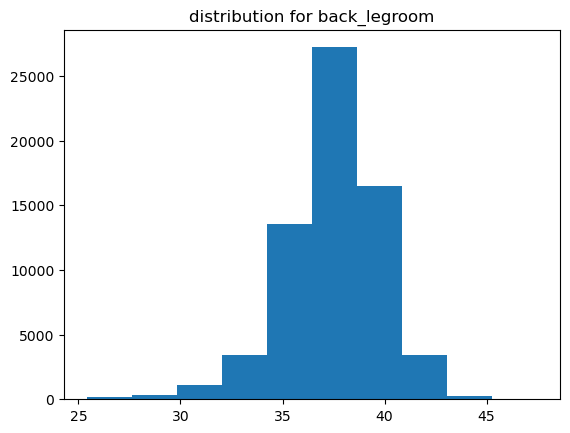

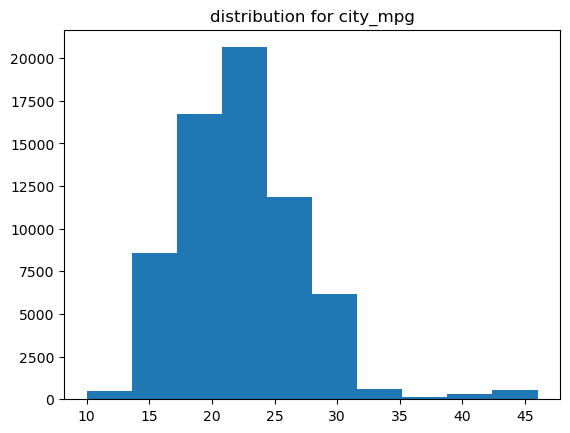

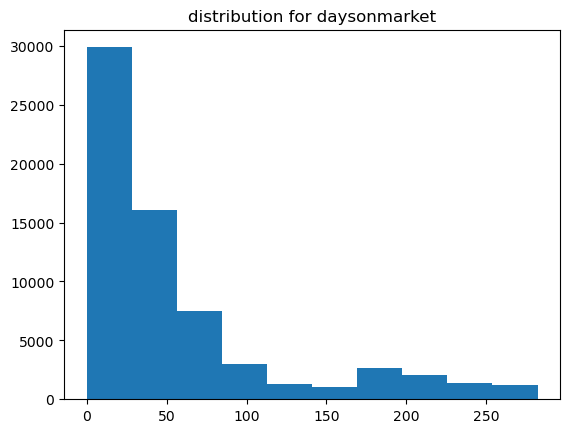

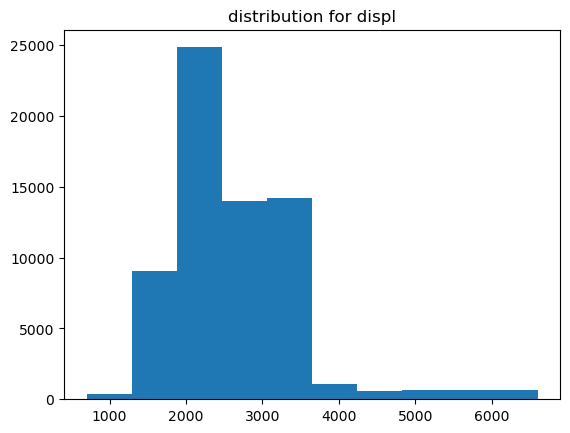

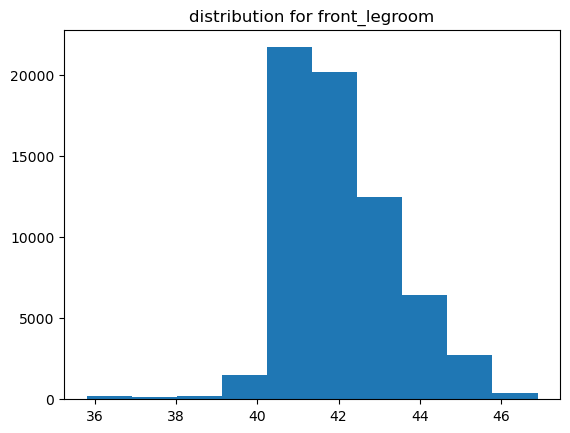

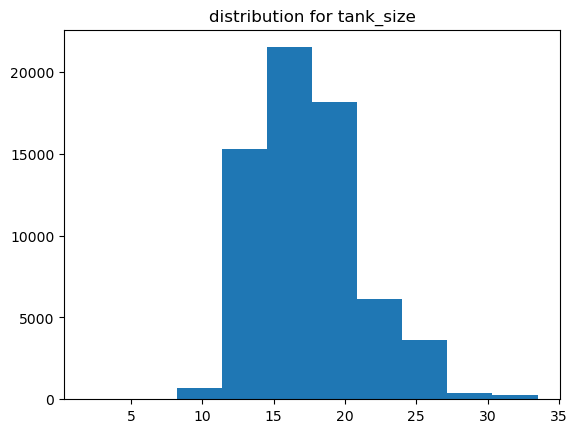

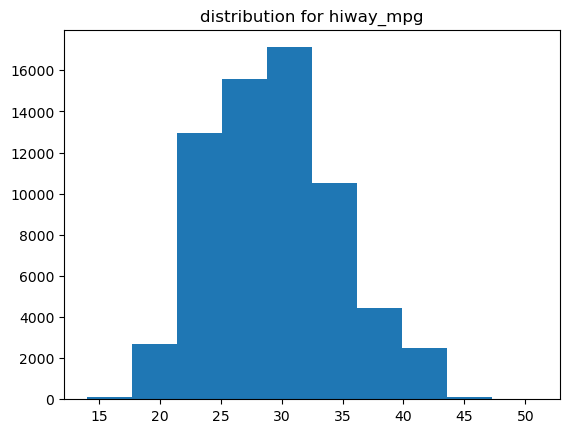

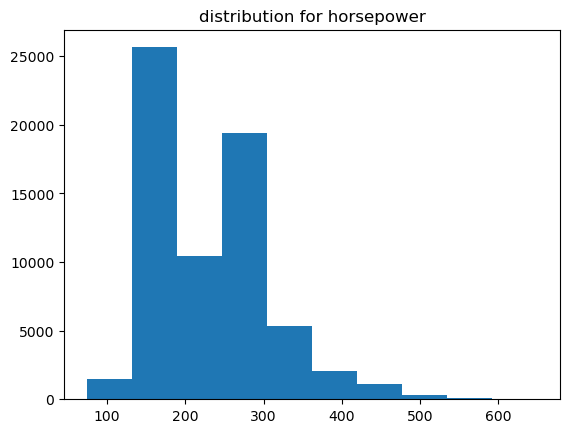

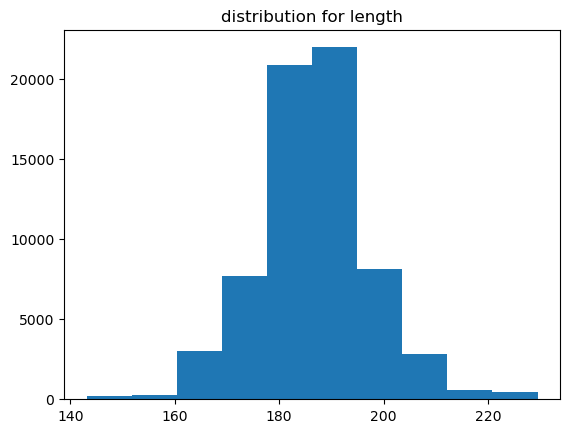

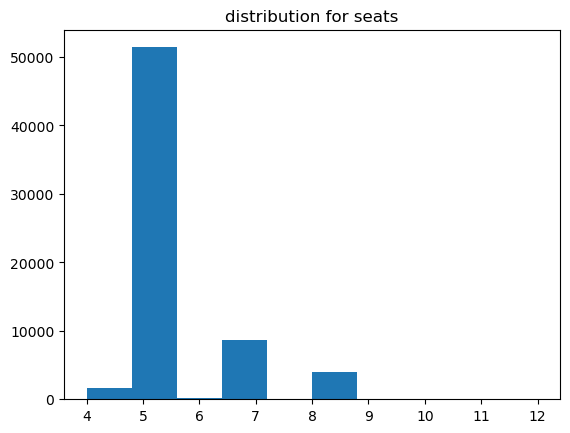

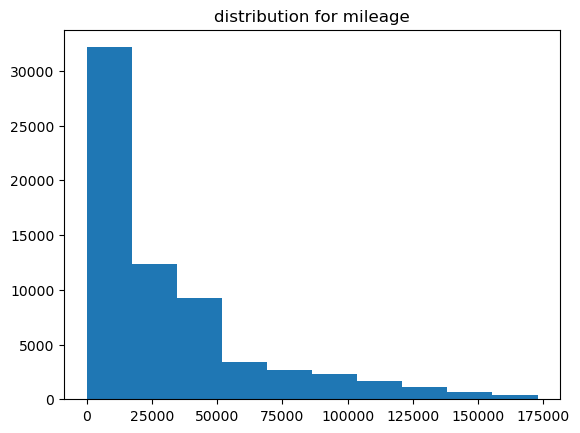

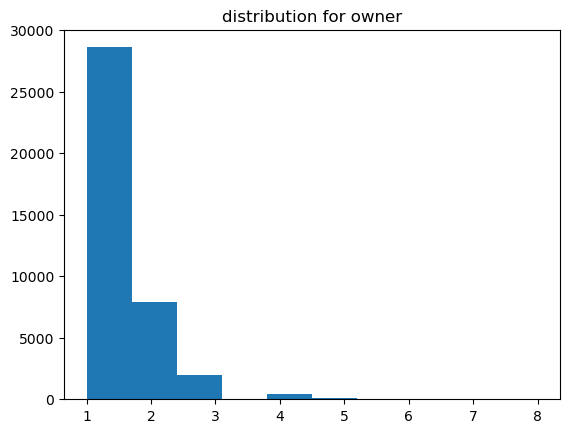

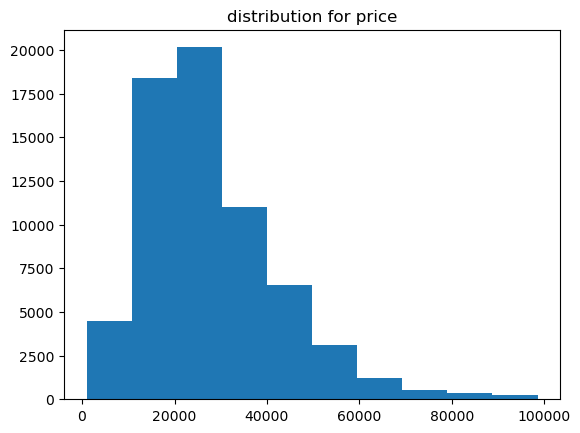

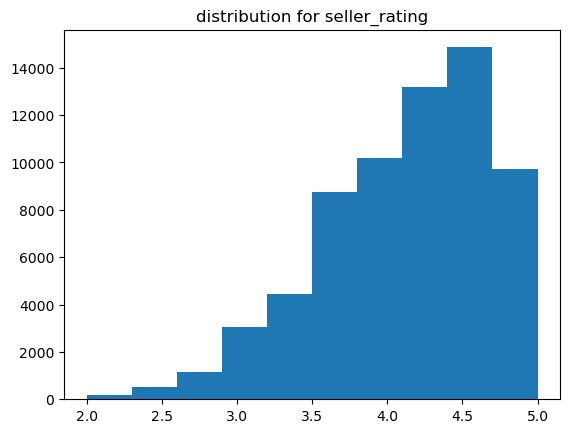

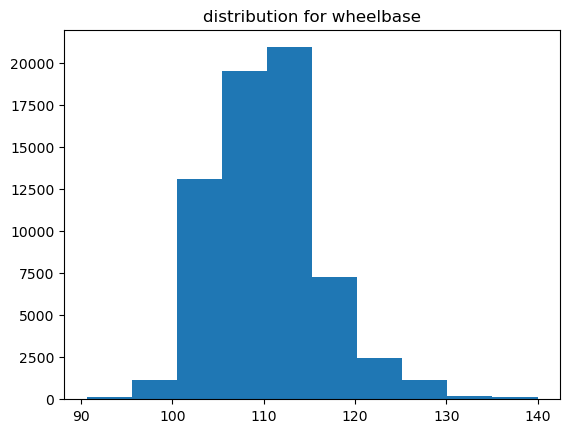

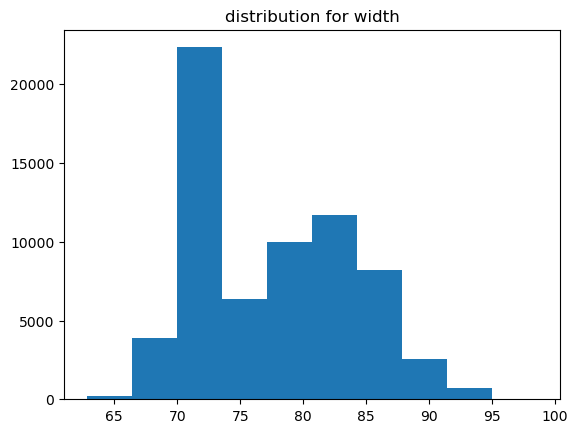

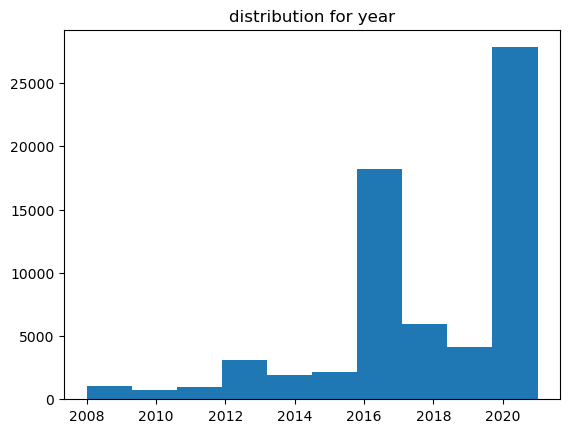

In [23]:
for col in col_list:
    
    plt.hist(df[col])
    plt.title(f'distribution for {col}')
    plt.show()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66025 entries, 38 to 99998
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   back_legroom   66025 non-null  float64
 1   body_type      64643 non-null  object 
 2   city           66025 non-null  object 
 3   city_mpg       66025 non-null  float64
 4   daysonmarket   66025 non-null  int64  
 5   cyl            66023 non-null  object 
 6   displ          66025 non-null  float64
 7   dealer         66025 non-null  bool   
 8   front_legroom  66025 non-null  float64
 9   tank_size      66025 non-null  float64
 10  fuel_type      66023 non-null  object 
 11  accidents      40587 non-null  object 
 12  hiway_mpg      66025 non-null  float64
 13  horsepower     66025 non-null  float64
 14  new            66025 non-null  bool   
 15  length         66025 non-null  float64
 16  listed_date    66025 non-null  object 
 17  model          66025 non-null  object 
 18  seats

<function matplotlib.pyplot.show(close=None, block=None)>

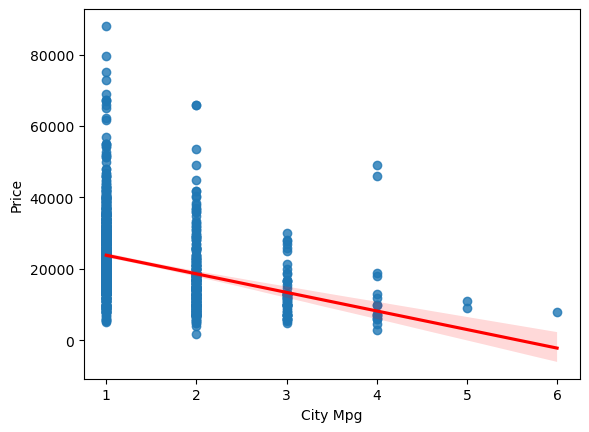

In [43]:
sns.regplot(x='owner', y='price', data=df.sample(2000), line_kws={'color':'red'})
plt.xlabel('City Mpg')
plt.ylabel('Price')
plt.show

In [44]:
for col in df.columns:
    
    print(f'{col} ', df[col].nunique())

back_legroom  149
body_type  8
city  406
city_mpg  37
daysonmarket  283
cyl  12
displ  46
dealer  2
front_legroom  71
tank_size  128
fuel_type  4
accidents  2
hiway_mpg  36
horsepower  287
new  2
length  453
listed_date  284
model  44
seats  8
mileage  32628
owner  8
price  19938
seller_rating  397
tranny  4
drive_type  5
wheelbase  228
width  213
year  14


<AxesSubplot:xlabel='drive_type', ylabel='price'>

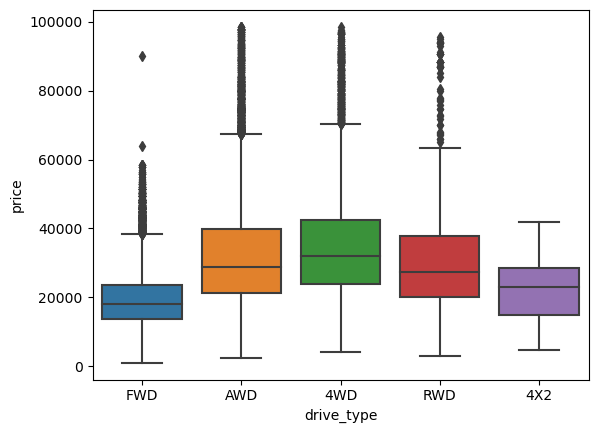

In [54]:
sns.boxplot(x='drive_type', y='price', data=df)


In [64]:
for col in col_list:
    
    r, p = stats.pearsonr(df[col], df['price'])
    
    print(f'Stats test for {col}: {r}, {p}')

Stats test for back_legroom: 0.1754636916883585, 0.0
Stats test for city_mpg: -0.3164682328887622, 0.0
Stats test for daysonmarket: 0.12335527109298783, 3.704980767257039e-222
Stats test for displ: 0.30225714291777245, 0.0
Stats test for front_legroom: -0.08625891671156527, 3.0396531418382853e-109
Stats test for tank_size: 0.41877793072163855, 0.0
Stats test for hiway_mpg: -0.3891536909233353, 0.0
Stats test for horsepower: 0.6042920873462744, 0.0
Stats test for length: 0.36509157572715156, 0.0
Stats test for seats: 0.24857937314367054, 0.0
Stats test for mileage: -0.5656606809884036, 0.0
Stats test for wheelbase: 0.4520074685731087, 0.0
Stats test for width: 0.4598969613774001, 0.0
Stats test for year: 0.5728694923668493, 0.0
